### Exercise 5 Notebook: Dimensionality Reduction with PCA & t-SNE on scRNA-seq Data

#### About this Exercise
This notebook focuses on two widely used dimensionality reduction techniques: **Principal Component Analysis (PCA)** and **t-Distributed Stochastic Neighbor Embedding (t-SNE)**. You will explore their application on **single-cell RNA sequencing (scRNA-seq)** data — a high-dimensional, real-world dataset from human blood cells (PBMCs).

💡 This is a valuable exercise for developing intuition about high-dimensional data and how dimensionality reduction methods help reveal structure in such datasets. These methods are also widely used in bioinformatics, computer vision, and any field dealing with many correlated features.

🚫 Please avoid using ChatGPT or other AI assistants to solve the tasks. Solving the problems yourself will help you truly understand the concepts and prepare better for the final exam.

#### Context:
In earlier sessions, you worked with pandas and sklearn on simpler datasets. Now you’ll experience working with **real-world high-dimensional biological data**. Each row in the dataset represents a single human immune cell, and each column represents the expression level of a gene. The cell types provided are actually resulted from a comperhensive analysis where marker genes where used to define cell type.

Since visualizing thousands of dimensions is impossible, PCA and t-SNE allow us to project the data down to 2 dimensions while trying to preserve meaningful structure. This is especially useful in scRNA-seq to distinguish cell types or discover subpopulations.

### Goal:
Your task is to:
- Preprocess the count matrix and reduce the dimensionality of the dataset
- Apply PCA and t-SNE, and visualize the results
- Experiment with parameter settings
- Reflect on the limitations and strengths of each method

Follow the Jupyter notebook below and answer the tasks marked as ✅ **Task for Students**.

In [1]:
# Exercise: Visualizing High-Dimensional Data with PCA and t-SNE
import pandas as pd
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

In [4]:
# read the annotated single Cell data
print("Loading data...")
df_pbmc= pd.read_pickle("pbmc3k_sparse.pkl")
df_pbmc.head()

Loading data...


,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,AL354822.1,KIR2DL2,AL590523.1,CT476828.1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1,cell_type
AAACATACAACCAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CD4 T cells
AAACATTGAGCTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B cells
AAACATTGATCAGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CD4 T cells
AAACCGTGCTTCCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CD14+ Monocytes
AAACCGTGTATGCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NK cells


In [5]:
df_pbmc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2638 entries, AAACATACAACCAC-1 to TTTGCATGCCTCAC-1
Columns: 32644 entries, MIR1302-10 to cell_type
dtypes: Sparse[float64, 0](32643), category(1)
memory usage: 25.7+ MB


## 1. ✅ Task 1: Drop all genes where the sum of genes expression across all cells is less than 10, these genes are not useful for this analysis

In [11]:
# Exclude 'cell_type' column to work only with gene expression values
# Keep only genes (columns) where at least one cell has more than 10 total genes expression across cells
# Reattach the 'cell_type' column
df = df_pbmc.drop('cell_type',axis = 1)
df
genes_kept =df.loc[:, df.sum(axis=0) > 10]

df = pd.concat([genes_kept,df_pbmc['cell_type']], axis=1)
df

,LINC00115,NOC2L,HES4,ISG15,C1orf159,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,cell_type
AAACATACAACCAC-1,0,0,0,0,0,0,0,0,0,0,...,5.0,1.0,0,10.0,1.0,0,4.0,0,0,CD4 T cells
AAACATTGAGCTAC-1,0,0,0,0,0,2.0,0,0,0,0,...,15.0,2.0,0,33.0,1.0,0,8.0,0,1.0,B cells
AAACATTGATCAGC-1,0,0,0,1.0,0,0,0,1.0,0,0,...,4.0,0,0,3.0,2.0,0,4.0,0,0,CD4 T cells
AAACCGTGCTTCCG-1,0,0,0,9.0,0,0,0,0,0,0,...,4.0,0,1.0,3.0,2.0,0,2.0,0,0,CD14+ Monocytes
AAACCGTGTATGCG-1,0,0,0,0,0,0,0,0,0,0,...,1.0,0,0,0,2.0,0,1.0,0,0,NK cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0,0,0,14.0,0,0,0,0,1.0,0,...,8.0,1.0,0,1.0,0,0,1.0,0,0,CD14+ Monocytes
TTTCTACTGAGGCA-1,0,0,0,1.0,0,0,0,0,0,0,...,7.0,0,1.0,2.0,1.0,0,4.0,0,0,B cells
TTTCTACTTCCTCG-1,0,0,0,0,0,0,0,0,0,0,...,7.0,0,0,7.0,0,0,4.0,0,0,B cells
TTTGCATGAGAGGC-1,0,0,0,0,0,0,0,0,0,0,...,2.0,0,1.0,0,0,0,1.0,0,0,B cells


## 2. ✅ Task 2: Standardize the data with sklearn standard scaler (since we are not developing ML models, you can use the whole data set as input)

In [14]:
# Dont forget to Convert to numpy and drop cell type since we want only to scale genes expressions 
# your code here

X = df.drop(columns='cell_type', axis = 1).to_numpy()
X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3. ✅ Task 3:  Apply PCA to 50 Dimensions on the Standardize data

In [16]:
# your code here
pca_50 =PCA(n_components= 50)

,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [18]:
X_pca_50 = pca_50.fit_transform(X_scaled)
X_pca_50

array([[-4.40840892e+00,  4.90316366e+00,  7.18884058e-01, ...,
        -9.82106550e-01,  3.80151408e-01,  2.33086497e+00],
       [ 2.08337662e+01,  2.06657705e+01, -8.50206604e-01, ...,
        -2.49873595e+00,  2.22419678e+01, -1.56686583e+01],
       [ 4.58741659e+00,  1.31513426e+01,  1.07491211e+00, ...,
        -3.22569188e+00, -3.11829819e+00,  2.08717842e+00],
       ...,
       [-9.83738959e+00, -3.09489959e+00, -4.10563511e-01, ...,
        -1.96249449e-02,  5.78078453e-01,  2.33719113e-01],
       [-1.37042611e+01, -9.32943568e+00,  5.61269162e-01, ...,
         9.40902966e-01,  5.20909012e-02, -6.70244741e-01],
       [-6.92205778e+00,  2.73826345e+00,  8.01276943e-01, ...,
         2.90866462e-01, -3.89593560e-01,  7.46957358e-01]],
      shape=(2638, 50))

## 4. ✅ Task 4:  Visualize the results with the top 2 PCs  using a scatter plot 

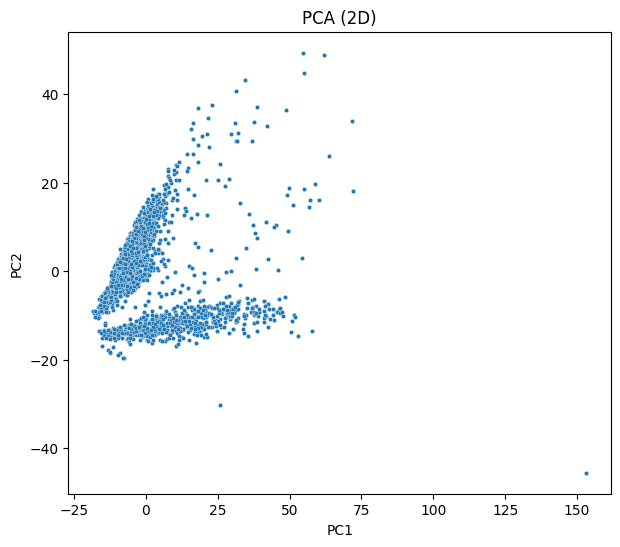

In [22]:
# use sns.scatterplot
# your code here
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca_50[:,0],y = X_pca_50[:,1],s =10)
# sns.scatterplot(x=X_pca_50[:,1],s = 10)
plt.title("PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
"""
OBSERVATION:
- There are 2 clear seperated clusters. This strongly suggests the PBMC dataset has sub-popuations of cells (T, B, NK, ..)
- PC1 ranges fomr -25 to 150 -> huge. Value of 150 could be outlier cell, or rare cell type.
- We only shows top 2 of 50 cells, this means the scatterplot doesnt show all preserved structure. PC1-PC2 might not capture meaningful clusters.
- PCA does not guarrantee actually biological clusters. To confirm this, we need t-SNE.
"""

## 5. ✅ Task 5: Apply t-SNE (after PCA to 50D), use default perplexity provided by sklearn TSNE function and two components

In [24]:
# use sklearn tSNE 
# your code here
print('Applying t-SNE...')
tsne=TSNE(n_components=2, perplexity=30,random_state=random_seed)
tsne

Applying t-SNE...


,n_components,2
,perplexity,30
,early_exaggeration,12.0
,learning_rate,'auto'
,max_iter,1000
,n_iter_without_progress,300
,min_grad_norm,1e-07
,metric,'euclidean'
,metric_params,None
,init,'pca'
,verbose,0


In [25]:
X_tsne = tsne.fit_transform(X_pca_50)
X_tsne

array([[ -4.34321  ,  11.336807 ],
       [-17.566488 , -34.27406  ],
       [  1.5294776,  28.664808 ],
       ...,
       [-25.48679  , -22.704573 ],
       [-21.774883 , -13.025188 ],
       [ -1.5278413,   9.019803 ]], shape=(2638, 2), dtype=float32)

## 6. ✅ Task 6: Visualize the results with scatterplot

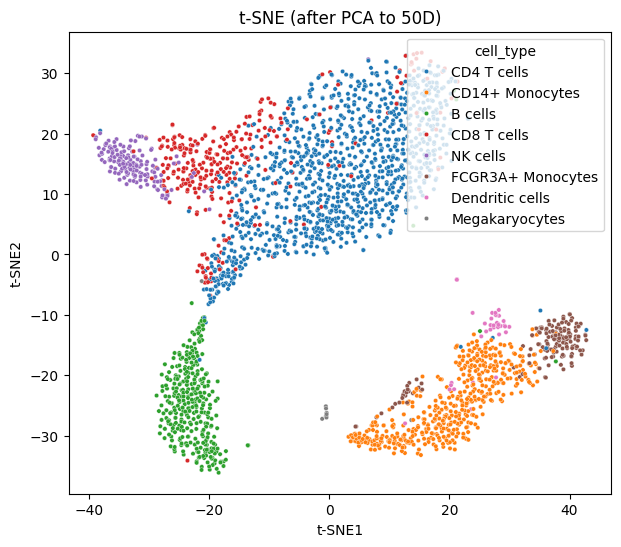

In [27]:
# use sns.scatterplot
# your code here
plt.figure(figsize=(7,6))
sns.scatterplot(x= X_tsne[:,0],y=X_tsne[:,1],hue=df_pbmc['cell_type'],s=10)
plt.title("t-SNE (after PCA to 50D)")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()


## 7. ✅ Task 7: Compare the PCA and t-SNE plots. What patterns do you observe?

In [ ]:
#  Replace the text below with your answer
answer_q7 = """ 
- t-SNE clearly preserve the local structure of gene clusters, how gene are seperated from the others by looking at the plot.
However, t-SNE does not have distance meaning of clusters.
- PCA continuously show the spread of cells without clear seperated groups, indicating that PCA preserve global structure.
- Do PCA before t-SNE helps to remove noise and speedup t-SNE.
"""

## 8. ✅ Task 8: Visualize the cell types on the tSNE embeddings

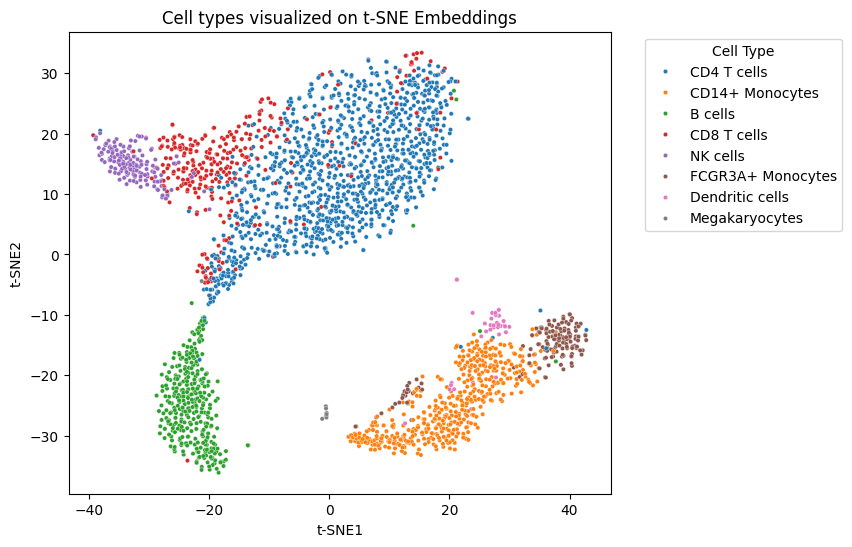

In [28]:
# use sns.scatterplot and leverage the hue option
# your code here

plt.figure(figsize=(7,6))
sns.scatterplot(x= X_tsne[:,0],y=X_tsne[:,1],hue=df['cell_type'],s=10) #hue = df['cell_type'] for visualize t-SNE embedding
plt.title(f"Cell types visualized on t-SNE Embeddings")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 9. ✅ Task 9: Try changing the perplexity in t-SNE (e.g., 2, 10, 50, 500).

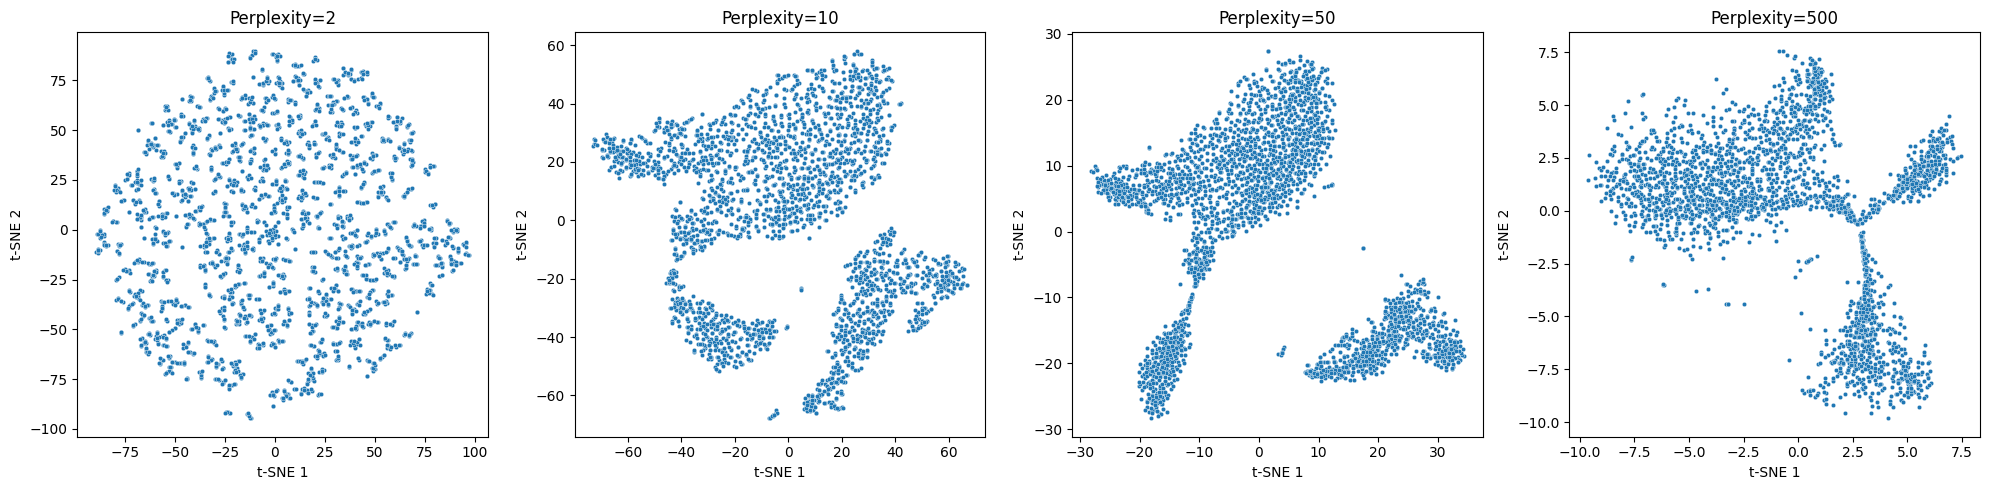

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 

for i, perplexity in enumerate([2, 10, 50, 500]):
    

    # Your code here
    tsne=TSNE(n_components=2, perplexity=perplexity, random_state=random_seed)
    tsne_result = tsne.fit_transform(X_pca_50)
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], s=10, ax=axs[i], legend=False)
    axs[i].set_title(f"Perplexity={perplexity}")
    axs[i].set_xlabel("t-SNE 1")
    axs[i].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()


 ## 10. ✅ Task 10: What happens to the result (answer below)?

In [ ]:
# Replace the text below with your answer
answer_q10 = """ 
With low perplexity =2, t-SNE produces many small, tight clusters.
At medium perplexity =10, the result is smoother, with better-defined larger clusters.
At large perplexity =50, 500, clusters appeear more blended and less distinct.
--> Change perplexity alter the balance between local and global structure in t-SNE embedding.
"""

## 11. ✅ Task 11: code a loop to run tSNE for three different random seeds, say [1, 42, 99].  For all runs, set preplexity to 30 and limit the maximum number of iterations to 500 and init="random".

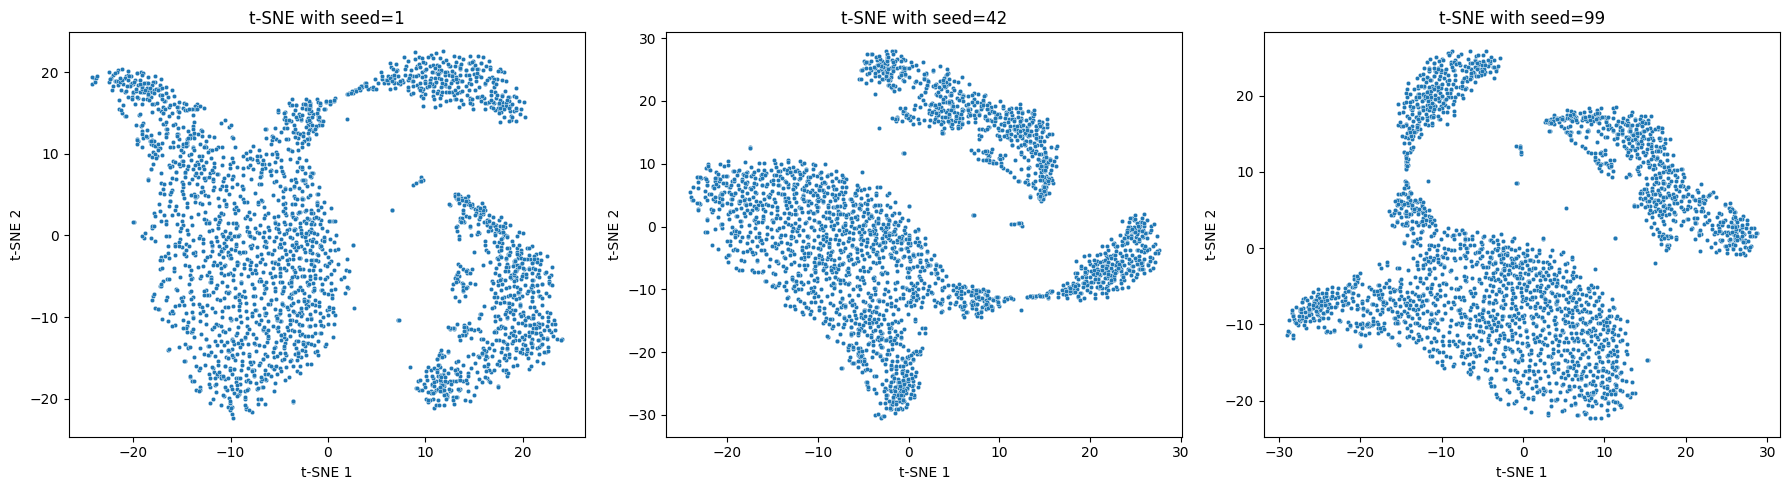

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, seed in enumerate([1, 42, 99]):
   
    # Your code here
    tsne = TSNE(n_components=2, max_iter=500, perplexity=30,random_state=seed,init = 'random')
    X_tsne= tsne.fit_transform(X_pca_50)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], s=10, ax=axs[i], legend=False)
    axs[i].set_title(f"t-SNE with seed={seed}")
    axs[i].set_xlabel("t-SNE 1")
    axs[i].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()


## 12. ✅ Task 12: Why do we have different results after changing the random seed?

In [ ]:
# Replace the text below with your answer
answer_q12 = """ 
Because t-SNE is a stochastic (non-deterministic algorithm). It involves random initialization and optimization steps that are sensitive to the starting point.
"""

13. ✅ Task for students: Try applying t-SNE directly on `X_scaled` (without PCA). How does the result change, compare visually with the results on X_pca_50? 

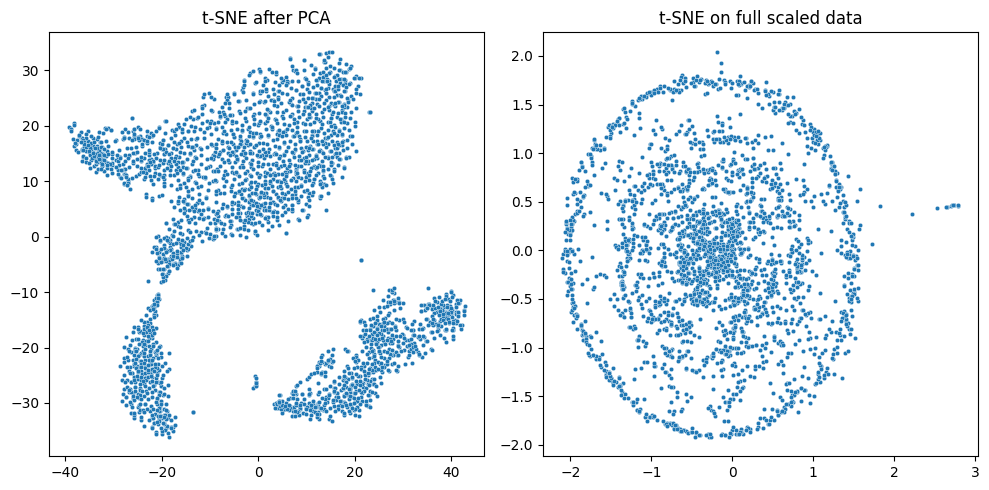

In [ ]:
# Use a scatter plot to visualize the tSNE on the scaled data vs. PCA-reduced data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# apply t-SNE on PCA-reduced data
tsne_pca = TSNE(n_components=2, random_state=random_seed, perplexity=30)
tsne_on_pca_result = tsne_pca.fit_transform(X_pca_50)
# apply t-SNE on raw scaled (full) data
tsne_scaled = TSNE(n_components=2, random_state=random_seed, perplexity=30)
tsne_on_full_scaled_data = tsne_scaled.fit_transform(X_scaled)
# Plot PCA-based t-SNE
sns.scatterplot(x = tsne_on_pca_result[:,0],y= tsne_on_pca_result[:,1],s=10, ax=axs[0])
axs[0].set_title(f"t-SNE after PCA")
# Plot scaled-data t-SNE
sns.scatterplot(x = tsne_on_full_scaled_data[:,0],y= tsne_on_full_scaled_data[:,1],s=10,ax=axs[1])
axs[1].set_title(f"t-SNE on full scaled data")

plt.tight_layout()
plt.show()

## 14. ✅ Task 14: why did using PCA before t-SNE help? or Why is PCA commonly applied before t-SNE on high-dimensional data?

In [ ]:
# Replace the text below with your answer
answer_q14 = """ 
PCA helps to remove outliers, maintain overall global structure, remove noise & variance.
Reduce computational cost and runtime.
"""